In [1]:
import os
import shutil
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 
import glob
import random
import tensorflow as tf
import keras.utils as image

random.seed(42)
tf.random.set_seed(42)

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import pickle
import keras_tuner as kt
import tensorflow.keras.backend as K

# Introduction

The goal of this notebook is to test the claims made in the [MobileNet paper](https://arxiv.org/abs/1704.04861). In summary, the paper asserts that by employing Depthwise Separable Convolution, width multiplier, and resolution multiplier, it is possible to create a fast model without sacrificing performance.

To investigate these claims, I built several models and compared their performance and computational requirements. Please note that this experiment is spread across multiple notebooks. I have numbered them to help readers follow the content without feeling overwhelmed. Each title indicates the focus of the corresponding notebook.

**Additional Notes**

* This is an imbalanced dataset. However, although I used only a portion of the total data (80,000 instances), I didn't alter its structure because I wanted to see whether the claims hold under different circumstances. I used 70% of the data for training and 15% each for validation and testing.

* To address imbalances, instead of using the accuracy metric, I used precision, recall, and F1 Score. If you can install tf.nightly, you can use tf.keras.metrics.F1Score(). I couldn't. I also tried to use tfa.metrics.F1Score() but since I used a single node in the last layer of the head, I had to set the number of classes to 1, which produced unreliable results (stuck at 0.44 from beginning to end). In addition, I assigned class weights. In other cases, I observed that the learning becomes unstable, primarily due to the disproportional distribution of the minority class among the batches.

* The references section can be found at the end of the last notebook.

* For hyperparameter optimization, I used Hyperband.

* The commented part in cell 5 is to create a data DataFrame. This helps shorten the preprocessing duration.

* Besides rescaling, I did not do any data augmentation techniques.

**Links for the Other Parts**

* [Part 2](https://www.kaggle.com/code/egemenuurdalg/cancer-detection-part-2-cnn-model/notebook)
* [Part 3](https://www.kaggle.com/code/egemenuurdalg/cancer-detection-part-3-vgg16-model/notebook)
* [Part 4](https://www.kaggle.com/code/egemenuurdalg/cancer-detection-part-4-resnet-model/notebook)
* [Part 5](https://www.kaggle.com/code/egemenuurdalg/cancer-detection-part-5-model-comparison?scriptVersionId=128244790)

# About the Model

The model used in this notebook is a combination of MobileNetV2 and a classification head. I froze the MobileNet part and only optimized the classification head. To achieve even better results, you can also unfreeze some parts of the MobileNet

# Content

1. [Reading the Data](#1)
2. [Model Optimization](#2)
3. [Training the Final Model](#3)
4. [Calculating the Number of Parameters and Amount of Mult Adds Needed](#4)

<a id='1'></a>
## 1. Reading the Data

In [2]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True,)

In [3]:
for i in range(5):
    print(breast_img[i])

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png


In [4]:
#difference occurs at -5 index
np.random.seed(42)
rand_list = np.random.randint(0,len(breast_img),5)
for i in rand_list:
    print(breast_img[i][-5])

1
0
1
0
1


In [5]:
#split the negative and positive cases
#negative_cases = []
#positive_cases = []

#for image in breast_img:
#    if image[-5] == "0": 
#        negative_cases.append(image)
        
#    elif image[-5] == "1":
#        positive_cases.append(image)
        
#combine the classes in a list of tuples and randomly sample 80,000 instances
#combined_images = [(path, 0) for path in negative_cases] + [(path, 1) for path in positive_cases]
#random.shuffle(combined_images)
#selected_images = combined_images[:80000]


#data = pd.DataFrame(selected_images, columns=["path", "label"])
#data.to_csv("selected_images.csv", index=False)

data = pd.read_csv("/kaggle/input/selected-images/selected_images.csv")

In [6]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)
val_data,test_data = train_test_split(val_data,test_size = 0.5, random_state = 42)


# Set preprocessing and hyperparameter settings
datagen = ImageDataGenerator(rescale=1./255)
target_size = (50, 50)
batch_size = 32

# Create the training, validation and test generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw')

val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw')

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col="path",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='raw')



Found 56000 validated image filenames.
Found 12000 validated image filenames.
Found 12000 validated image filenames.


In [7]:
#determine the class weights based on frequencies of classes in training data
A,B = np.unique(train_generator.labels, return_counts = True)
n = len(train_generator.labels)
cls_weights = {i:(n-j)/n for i,j in zip(A,B)}

In [8]:
# If tf.nightly works in your notebook you can also use tf.keras.metrics.F1Score()
# Don't recommend to use tfa.metrics.F1Score() cause the results are not reliable. You have to enter number of classes as 1 since output node has one units.
# When you run the model based on that the F1 Score stucks at 0.44 in all iterations
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

<a id='2'></a>
## 2. Model Optimization

In [9]:
#build transfer learning model
#def hp_model(hp):
    
#    pre = MobileNetV2(input_shape = (50, 50, 3),
#               include_top=False,
#               pooling = 'max')

    #Freeze the model
#    for layer in pre.layers:
#        layer.trainable = False

#    units = hp.Int("Dense_units",min_value = 50, max_value = 100, step = 10)
#    x = tf.keras.layers.Dense(units, activation = 'relu')(pre.output)
#    x = tf.keras.layers.Dense(units/2,activation = 'relu')(x)
#    out = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

#    transfer_learning_model = tf.keras.models.Model(pre.input,out)

#    hp_learning_rate = hp.Choice('learning_rate',[1e-2,1e-3,1e-4])
#    transfer_learning_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
#                                   loss = tf.keras.losses.BinaryCrossentropy(),
#                                   metrics = [tf.keras.metrics.Recall(),
#                                             tf.keras.metrics.Precision(),
#                                             f1_score])

#    return transfer_learning_model 

In [10]:
#tuner = kt.Hyperband(hp_model,
#                     objective=kt.Objective('f1_score', 'max'),
#                     max_epochs=10,
#                     factor=3,
#                     directory='my_dir',
#                     project_name='MobileNet_Optimization')

In [11]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#tuner.search(train_generator, epochs=50, validation_data = val_generator, callbacks=[stop_early])

# Get the optimal hyperparameters
#best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



In [12]:
#print(f"""
#The hyperparameter search is complete. The optimal number of units in the first densely-connected
#layer is {best_hps.get('Dense_units')} and the optimal learning rate for the optimizer
#is {best_hps.get('learning_rate')}.
#""")

<a id='3'></a>
## 3. Training the Final Model

In [13]:
 def train_best_model(learning_rate,units):
        
    
    pre = MobileNetV2(input_shape = (50, 50, 3),
               include_top=False,
               pooling = 'max')

    #Freeze the model
    for layer in pre.layers:
        layer.trainable = False

    
    x = tf.keras.layers.Dense(units, activation = 'relu')(pre.output)
    x = tf.keras.layers.Dense(units/2,activation = 'relu')(x)
    out = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

    transfer_learning_model = tf.keras.models.Model(pre.input,out)

    
    transfer_learning_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                                   loss = tf.keras.losses.BinaryCrossentropy(),
                                   metrics = [tf.keras.metrics.Recall(),
                                             tf.keras.metrics.Precision(),
                                             f1_score])
    
    history = transfer_learning_model.fit(train_generator,epochs = 300, validation_data = val_generator,
                                         callbacks = tf.keras.callbacks.EarlyStopping(patience = 5,
                                                                                     min_delta = 0.001),
                                         class_weight = cls_weights)
    test_results = transfer_learning_model.evaluate(test_generator)
    
    return transfer_learning_model,history,test_results

In [14]:
#results obtained from keras tuner
best_params = {
    'units':90,
    'learning_rate' : 0.001
}

model,history,test_results = train_best_model(**best_params)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/300
1750/1750 [==============================] - 514s 285ms/step - loss: 0.1907 - recall: 0.7674 - precision: 0.6083 - f1_score: 0.6685 - val_loss: 0.5787 - val_recall: 0.9019 - val_precision: 0.4797 - val_f1_score: 0.6159
Epoch 2/300
1750/1750 [==============================] - 124s 71ms/step - loss: 0.1787 - recall: 0.7943 - precision: 0.6229 - f1_score: 0.6873 - val_loss: 0.4450 - val_recall: 0.8207 - val_precision: 0.6032 - val_f1_score: 0.6849
Epoch 3/300
1750/1750 [==============================] - 117s 67ms/step - loss: 0.1732 - recall: 0.8028 - precision: 0.6289 - f1_score: 0.6946 - val_loss: 0.4295 - val_recall: 0.7962 - val_precision: 0.6244 - val_f1_score: 0.6901
Epoch 4/300
1750/1750 [==============================] - 116s 66ms/step - loss: 0.1677 - recall: 0.8122 - precision: 0.6390 - f1_score: 0.7056 - val_loss: 0.4584 - val_recall: 0.8314 - val_precision: 0.5940 - val_f1_score: 0.6828
Epoch 5/300
1750

In [15]:
model.save('transfer_learning_model.h5')

with open('transfer_learning_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
    
with open('transfer_learning_test_results.pkl', 'wb') as file:
    pickle.dump(test_results, file)
    

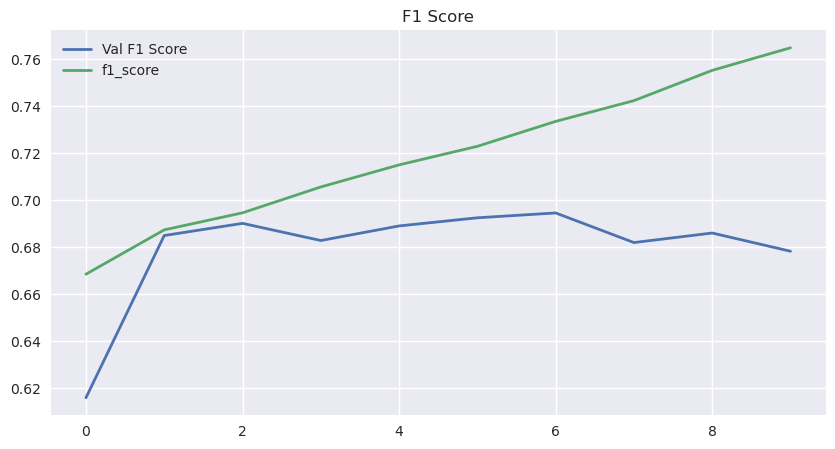

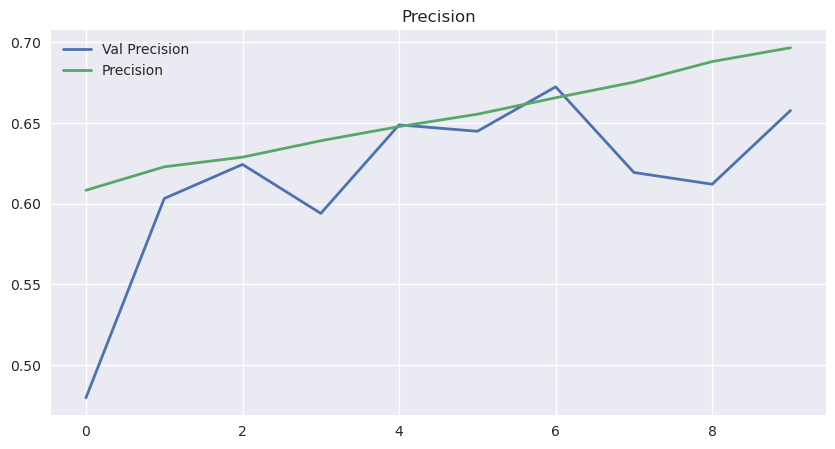

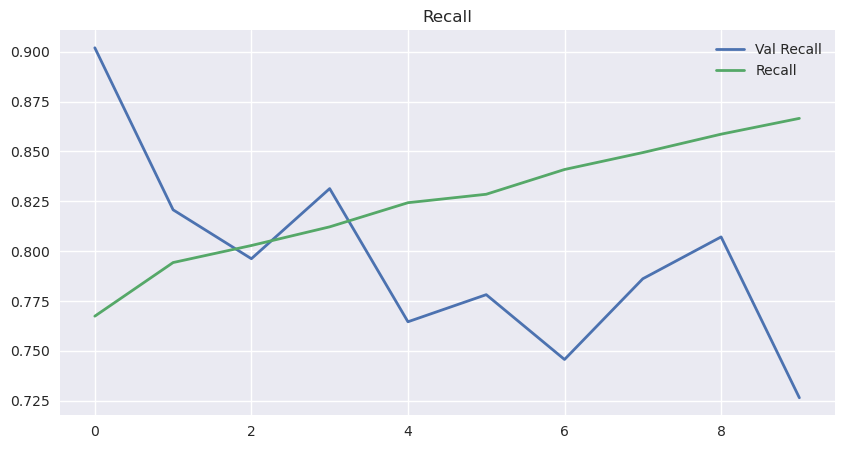

In [16]:
def plot_the_results(history):
    plt.style.use('seaborn')
    plt.figure(figsize = (10,5))
    plt.plot(history.epoch,history.history['val_f1_score'], label = 'Val F1 Score',linewidth=2)
    plt.plot(history.epoch,history.history['f1_score'], label = 'f1_score',linewidth=2)
    plt.legend()
    plt.title('F1 Score')
    plt.show()

    plt.figure(figsize = (10,5))
    plt.plot(history.epoch,history.history['val_precision'], label = 'Val Precision',linewidth=2)
    plt.plot(history.epoch,history.history['precision'], label = 'Precision',linewidth=2)
    plt.legend()
    plt.title('Precision')
    plt.show()
    
    plt.figure(figsize = (10,5))
    plt.plot(history.epoch,history.history['val_recall'], label = 'Val Recall',linewidth=2)
    plt.plot(history.epoch,history.history['recall'], label = 'Recall',linewidth=2)
    plt.legend()
    plt.title('Recall')
    plt.show()
    
plot_the_results(history)

In [17]:
print("Test Results")
print("\n-------------\n")
print("Test Loss:",format(test_results[0],'.3f'))
print("Test Precision: ",format(test_results[1], '.3f'))
print("Test Recall: ", format(test_results[2],'.3f'))

Test Results

-------------

Test Loss: 0.439
Test Precision:  0.725
Test Recall:  0.643


<a id='4'></a>
## 4. Calculating the Number of Parameters and Amount of Mult Adds Needed

In [18]:
total_parameters = model.count_params()
mult_adds_total = 0
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        height, width, channels_in = layer.input_shape[1:]
        _, _, channels_out = layer.output_shape[1:]
        kernel_height, kernel_width = layer.kernel_size

        mult_adds = height * width * channels_in * channels_out * kernel_height * kernel_width
        mult_adds_total += mult_adds
        
        
print("Total parameters:", total_parameters)
print("Total number of multipy-accumulates:", mult_adds_total)

Total parameters: 2377415
Total number of multipy-accumulates: 21583104
